In [ ]:
import pandas as pd 
import numpy as np 
import sys
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold,RFE, mutual_info_classif
from scipy.stats import spearmanr,pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold


sys.path.append("../scripts/")

In [26]:
from feature_creation import * 
from training import create_groupkfolds
import config

In [4]:
df = pd.read_csv(config.TRAINING_DATA_PATH)

In [5]:
model = 'adhoc'
fold = 0

if not os.path.exists(f'../resources/{model}'):
        os.makedirs(f'../resources/{model}')

feature_pipeline = Pipeline(steps=[
                ("Language Features",LanguageFeature()),
                ("Graph Features",GraphFeatures()),
                ("Node Features",NodeFeatures()),
                ("Dataset Creation",FormatDataFrame()),
                ("Language One Hot Encoding",LanguageOHE(enc_lan=f"{model}/lan_encoder_{model}_{fold}.pkl",\
                                                         enc_lan_family=f"{model}/lan_family_encoder_{model}_{fold}.pkl"))  
            ])

In [6]:
data = feature_pipeline.fit_transform(df)

Langauge Feature Started
Langauge Feature Ended
Graph Features Creation Started
Graph Feature Creation Ended
Node Features Creation Started
Node Features Creation Ended
DataFrame Creation Started
DataFrame Creation Ended!!
One Hot Encoding Started
One Hot Encoding created and Saved


In [7]:
x_train_data = data.drop(columns=['sentence','is_root','node_number','language','language_group'])
y_train_data = data[['is_root']]

In [8]:
scaler = MinMaxScaler()
data_scaled = x_train_data.copy()
data_scaled = pd.DataFrame(scaler.fit_transform(data_scaled),columns=data_scaled.columns)

##  Variance of the Features

In [8]:
variance_series = data_scaled.var()

In [9]:
df_variance = variance_series.reset_index()
df_variance.columns = ['feature', 'variance']
df_variance_sorted = df_variance.sort_values(by='variance', ascending=True).reset_index(drop=True)

In [14]:
df_variance_sorted.describe()

variance
count  85.000000
mean    0.037354
std     0.042836
min     0.001289
25%     0.012271
50%     0.022911
75%     0.045403
max     0.243069

In [52]:
df_variance_sorted

feature  variance
0          information_cent  0.001289
1    current_flow_closeness  0.001289
2     subtree_size_variance  0.004662
3                 page_cent  0.005809
4               degree_cent  0.006375
..                      ...       ...
80    language_group_Slavic  0.107486
81  language_group_Germanic  0.148422
82   language_group_Romance  0.198049
83   participation_diameter  0.229416
84                  is_leaf  0.243069

[85 rows x 2 columns]

In [10]:
def select_features_by_correlation(features_df, correlation_threshold=0.90, method='pearson', 
                                   plot_correlation=True, figsize=(12, 10)):
    
    print(f"Original features: {features_df.shape[1]}")
    
    # Calculate correlation matrix
    correlation_matrix = features_df.corr(method=method).abs()
    
    # Plot correlation matrix if requested
    if plot_correlation:
        plt.figure(figsize=figsize)
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
                    linewidths=0.5, vmin=0, vmax=1)
        plt.title(f'Feature Correlation Matrix ({method.capitalize()} Correlation)')
        plt.tight_layout()
        plt.show()
    
    # Find features to remove
    features_to_remove = []
    
    # For each feature, check if it has high correlation with other features
    # and if so, remove the one with higher mean correlation with all other features
    feature_names = list(correlation_matrix.columns)
    for i in range(len(feature_names)):
        if feature_names[i] in features_to_remove:
            continue
            
        for j in range(i + 1, len(feature_names)):
            if feature_names[j] in features_to_remove:
                continue
                
            # Check if correlation exceeds threshold
            if correlation_matrix.iloc[i, j] > correlation_threshold:
                # Calculate mean correlation for both features
                mean_corr_i = correlation_matrix.iloc[i, :].mean()
                mean_corr_j = correlation_matrix.iloc[j, :].mean()
                
                # Remove the feature with higher mean correlation
                if mean_corr_i > mean_corr_j:
                    features_to_remove.append(feature_names[i])
                    print(f"Removing {feature_names[i]} (correlated with {feature_names[j]}, {correlation_matrix.iloc[i, j]:.3f})")
                    break  # Break the inner loop as we've removed feature i
                else:
                    features_to_remove.append(feature_names[j])
                    print(f"Removing {feature_names[j]} (correlated with {feature_names[i]}, {correlation_matrix.iloc[i, j]:.3f})")
    
    # Select the features to keep
    features_to_keep = [f for f in feature_names if f not in features_to_remove]
    
    print(f"Removed {len(features_to_remove)} features due to high correlation (>{correlation_threshold}).")
    print(f"Kept {len(features_to_keep)} features.")
    
    # Create the filtered dataframe
    selected_df = features_df[features_to_keep]
    
    return selected_df, features_to_remove, correlation_matrix


In [14]:
x_train_data = x_train_data.drop(columns=['information_cent','current_flow_closeness'])

Original features: 83


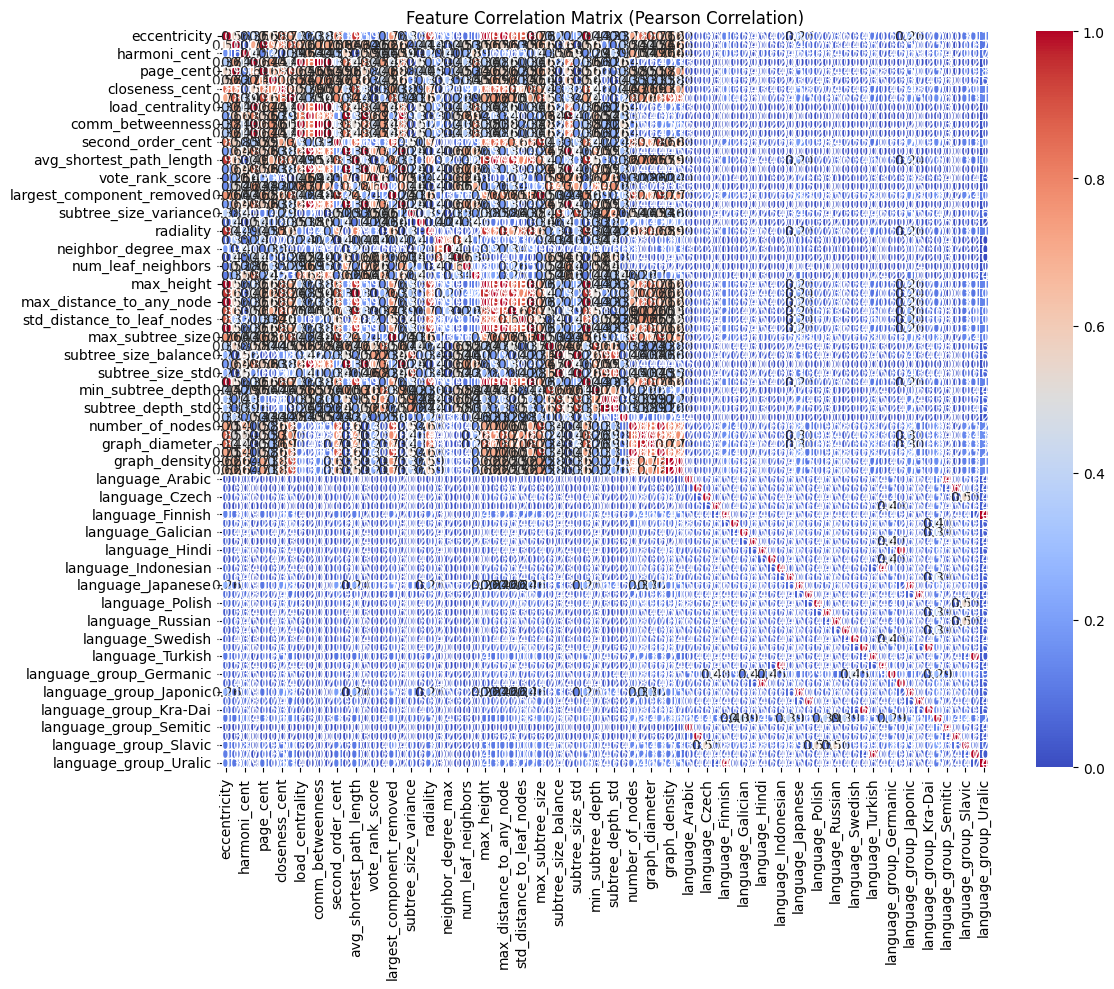

Removing avg_shortest_path_length (correlated with eccentricity, 0.946)
Removing eccentricity (correlated with radiality, 0.948)
Removing degree_cent (correlated with page_cent, 0.995)
Removing load_centrality (correlated with betweeness_cent, 1.000)
Removing comm_betweenness (correlated with betweeness_cent, 0.999)
Removing betweeness_cent (correlated with current_flow_betweenness, 1.000)
Removing katz_cent (correlated with page_cent, 0.905)
Removing degree (correlated with subgraph_cent, 0.990)
Removing effective_size (correlated with subgraph_cent, 0.990)
Removing num_subtrees_removed (correlated with subgraph_cent, 0.990)
Removing num_subtrees (correlated with subgraph_cent, 0.990)
Removing largest_component_removed (correlated with second_order_cent, 0.940)
Removing max_subtree_size (correlated with second_order_cent, 0.940)
Removing subtree_size_std (correlated with subtree_size_variance, 0.910)
Removing max_height (correlated with radiality, 0.948)
Removing max_distance_to_any_n

In [15]:
selected_data, feat_remove, corr_mat = select_features_by_correlation(x_train_data)

In [17]:
feat_remove

['avg_shortest_path_length',
 'eccentricity',
 'degree_cent',
 'load_centrality',
 'comm_betweenness',
 'betweeness_cent',
 'katz_cent',
 'degree',
 'effective_size',
 'num_subtrees_removed',
 'num_subtrees',
 'largest_component_removed',
 'max_subtree_size',
 'subtree_size_std',
 'max_height',
 'max_distance_to_any_node',
 'distance_to_farthest_leaf',
 'max_subtree_depth',
 'avg_distance_to_all_nodes',
 'min_subtree_size',
 'subtree_depth_balance',
 'subtree_size_balance',
 'graph_num_edges',
 'graph_avg_path_length',
 'graph_average_degree',
 'language_group_Semitic',
 'language_Chinese',
 'language_group_Uralic',
 'language_group_Indo-Aryan',
 'language_group_Austronesian',
 'language_group_Japonic',
 'language_group_Koreanic',
 'language_group_Kra-Dai',
 'language_group_Turkic']

In [20]:
def feature_correlation_with_target(features_df, target_series, method='spearman', plot=True, figsize=(14, 6)):
    """
    Calculate correlation of features with a target variable and sort by absolute correlation.
    
    Parameters:
    -----------
    features_df : pd.DataFrame
        DataFrame containing feature values with nodes as index
    target_series : pd.Series
        Series containing target values with same index as features_df
    method : str, default='spearman'
        Method to calculate correlation ('pearson' or 'spearman')
    plot : bool, default=True
        Whether to plot feature correlations with target
    figsize : tuple, default=(14, 6)
        Size of the plot
        
    Returns:
    --------
    pd.Series
        Series with feature-target correlations sorted by absolute value
    """
    # Ensure target_series has the same index as features_df
    if not all(target_series.index == features_df.index):
        raise ValueError("Target series must have the same index as features DataFrame")
    
    # Calculate correlation with target for each feature
    correlations = {}
    p_values = {}
    
    for feature in features_df.columns:
        if method == 'pearson':
            corr, p_val = pearsonr(features_df[feature], target_series)
        elif method == 'spearman':
            corr, p_val = spearmanr(features_df[feature], target_series)
        else:
            raise ValueError("Method must be 'pearson' or 'spearman'")
        
        correlations[feature] = corr
        p_values[feature] = p_val
    
    # Convert to Series and sort by absolute correlation
    corr_series = pd.Series(correlations)
    p_val_series = pd.Series(p_values)
    sorted_corr = corr_series.reindex(corr_series.abs().sort_values(ascending=False).index)
    
    # Create DataFrame with correlations and p-values
    result_df = pd.DataFrame({
        'correlation': sorted_corr,
        'p_value': p_val_series[sorted_corr.index],
        'significant': p_val_series[sorted_corr.index] < 0.05
    })
    
    # Print results
    print(f"Feature correlations with target ({method}):")
    for feature, corr, p_val, sig in zip(result_df.index, 
                                       result_df['correlation'], 
                                       result_df['p_value'],
                                       result_df['significant']):
        sig_mark = "**" if sig else ""
        print(f"{feature:<30} {corr:>8.3f} (p={p_val:.3f}) {sig_mark}")
    
    # Plot correlations
    if plot:
        plt.figure(figsize=figsize)
        colors = ['green' if c >= 0 else 'red' for c in sorted_corr]
        bars = plt.bar(range(len(sorted_corr)), sorted_corr, color=colors)
        plt.xticks(range(len(sorted_corr)), sorted_corr.index, rotation=90)
        plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        plt.title(f'Feature Correlation with Target ({method.capitalize()})')
        plt.ylabel('Correlation')
        plt.tight_layout()
        plt.show()
    
    return result_df

Feature correlations with target (spearman):
betweeness_cent                   0.259 (p=0.000) **
load_centrality                   0.259 (p=0.000) **
current_flow_betweenness          0.254 (p=0.000) **
comm_betweenness                  0.252 (p=0.000) **
degree_cent                       0.240 (p=0.000) **
num_subtrees                      0.236 (p=0.000) **
effective_size                    0.236 (p=0.000) **
degree                            0.236 (p=0.000) **
num_subtrees_removed              0.236 (p=0.000) **
page_cent                         0.229 (p=0.000) **
eigen_cent                        0.222 (p=0.000) **
subgraph_cent                     0.222 (p=0.000) **
avg_distance_to_leaf_nodes       -0.203 (p=0.000) **
closeness_cent                    0.201 (p=0.000) **
avg_shortest_path_length         -0.201 (p=0.000) **
avg_distance_to_all_nodes        -0.198 (p=0.000) **
katz_cent                         0.194 (p=0.000) **
node_step_removal                 0.193 (p=0.000) **
m

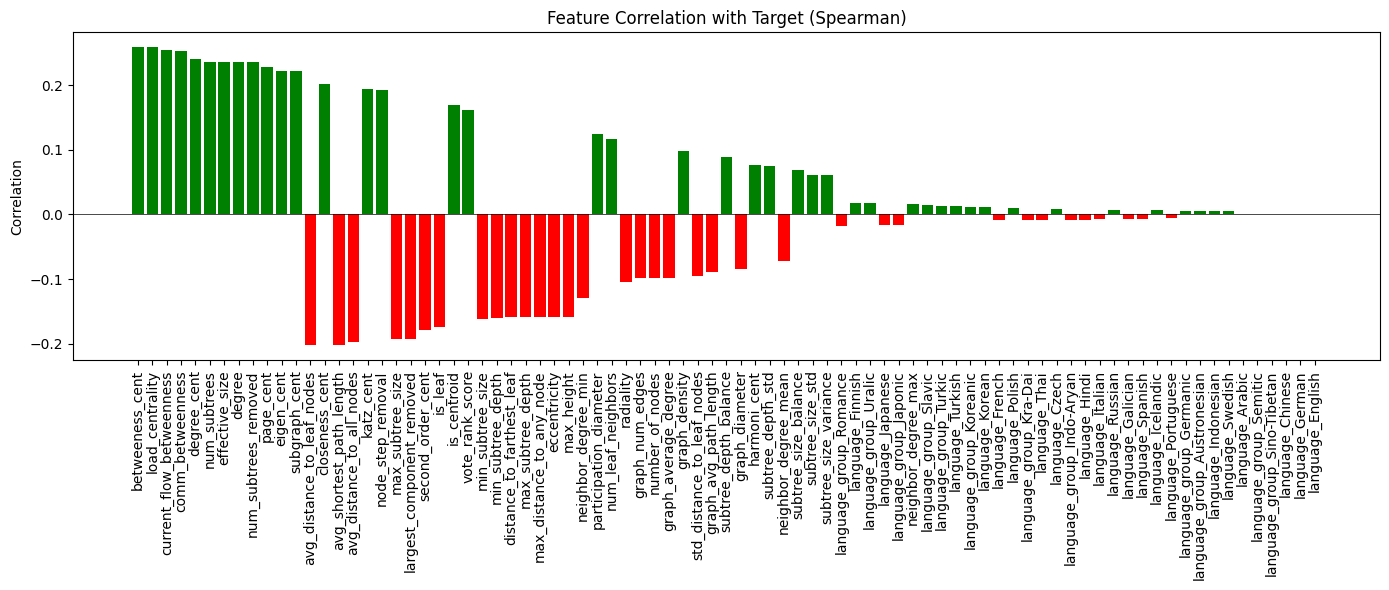

In [21]:
res_df = feature_correlation_with_target(x_train_data,y_train_data)

In [24]:
res_df[res_df['significant']==True]

correlation   p_value  significant
betweeness_cent                 0.258553  0.000000         True
load_centrality                 0.258553  0.000000         True
current_flow_betweenness        0.253788  0.000000         True
comm_betweenness                0.252150  0.000000         True
degree_cent                     0.240418  0.000000         True
...                                  ...       ...          ...
language_Portuguese            -0.005781  0.010193         True
language_group_Germanic         0.005654  0.011993         True
language_group_Austronesian     0.004880  0.030124         True
language_Indonesian             0.004880  0.030124         True
language_Swedish                0.004566  0.042432         True

[77 rows x 3 columns]

## RFE

In [43]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import get_scorer
from tqdm import tqdm
import lightgbm as lgb

def incremental_feature_selection(X, y, groups, estimator=None, metric='log_loss', cv=5, 
                                direction='forward', max_features=None, min_improvement=0.001, 
                                patience=3, random_state=42, normalize=True, verbose=True, plot=True):
    """Modified version with GroupKFold and log loss scoring"""
    
    # Set up CV and scoring
    cv_folds = GroupKFold(n_splits=cv)
    
    # Handle log loss scoring
    if metric == 'log_loss':
        scorer = get_scorer('neg_log_loss')
    else:
        scorer = get_scorer(metric)

    # Initialize tracking variables
    performance_history = []
    feature_history = []
    best_score = -np.inf if direction == 'forward' else np.inf
    best_actual_score = np.inf if metric == 'log_loss' else -np.inf
    iterations_without_improvement = 0
    feature_scores = {f: {'added_at': None, 'score_improvement': 0} for f in X.columns}

    # Feature set initialization
    if direction == 'forward':
        selected_features = []
        remaining_features = list(X.columns)
        max_features = min(max_features or len(X.columns), len(X.columns))
    else:
        selected_features = list(X.columns)
        remaining_features = []
        max_features = len(X.columns) - (max_features or 0)

    # Main loop
    start_time = time.time()
    pbar = tqdm(total=max_features, disable=not verbose)
    
    while (len(selected_features) < max_features and direction == 'forward') or \
          (len(selected_features) > max_features and direction == 'backward'):
        
        best_feature = None
        best_iter_score = -np.inf if direction == 'forward' else np.inf
        best_actual = np.inf if metric == 'log_loss' else -np.inf

        candidates = remaining_features if direction == 'forward' else selected_features
        
        for feature in candidates:
            current_features = (selected_features + [feature]) if direction == 'forward' else \
                              [f for f in selected_features if f != feature]
            
            if not current_features:
                continue

            X_subset = X[current_features]
            cv_scores = cross_val_score(estimator, X_subset, y, 
                                      groups=groups, 
                                      cv=cv_folds, 
                                      scoring=scorer,
                                      n_jobs=-1)
            
            score = np.mean(cv_scores)
            actual_score = -score if metric == 'log_loss' else score

            if ((direction == 'forward' and score > best_iter_score) or 
                (direction == 'backward' and score > best_iter_score)):
                best_iter_score = score
                best_feature = feature
                best_actual = actual_score

        # Calculate improvement
        if metric == 'log_loss':
            improvement = best_iter_score - best_score
            actual_improvement = best_actual_score - best_actual
        else:
            improvement = best_iter_score - best_score
            actual_improvement = improvement

        # Update feature sets
        if best_feature:
            if direction == 'forward':
                selected_features.append(best_feature)
                remaining_features.remove(best_feature)
                feature_scores[best_feature]['added_at'] = len(selected_features)
                feature_scores[best_feature]['score_improvement'] = actual_improvement
                pbar.update(1)
                desc = f"Added: {best_feature} (Log Loss: {best_actual:.4f}, Δ{-actual_improvement:.4f})"
            else:
                selected_features.remove(best_feature)
                remaining_features.append(best_feature)
                feature_scores[best_feature]['removed_at'] = len(selected_features)
                feature_scores[best_feature]['score_impact'] = actual_improvement
                desc = f"Removed: {best_feature} (Log Loss: {best_actual:.4f}, Δ{-actual_improvement:.4f})"
            
            pbar.set_description(desc)

        # Track performance
        performance_history.append(best_actual if metric == 'log_loss' else best_iter_score)
        feature_history.append(selected_features.copy())

        # Update best scores
        if metric == 'log_loss':
            if actual_improvement > min_improvement:
                best_score = best_iter_score
                best_actual_score = best_actual
                iterations_without_improvement = 0
            else:
                iterations_without_improvement += 1
        else:
            if improvement > min_improvement:
                best_score = best_iter_score
                iterations_without_improvement = 0
            else:
                iterations_without_improvement += 1

        # Early stopping
        if iterations_without_improvement >= patience:
            if verbose: print(f"Early stopping after {patience} iterations without improvement")
            break

    pbar.close()
    
    # Find optimal feature set
    optimal_idx = np.argmin(performance_history) if metric == 'log_loss' else np.argmax(performance_history)
    optimal_features = feature_history[optimal_idx]
    optimal_score = performance_history[optimal_idx]

    # Plotting
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(performance_history, marker='o')
        plt.axvline(optimal_idx, color='r', linestyle='--')
        plt.title(f'Feature Selection Performance ({metric})')
        plt.xlabel('Iteration')
        plt.ylabel('Log Loss' if metric == 'log_loss' else metric)
        plt.show()

    return X[optimal_features], {
        'optimal_features': optimal_features,
        'optimal_score': optimal_score,
        'performance_history': performance_history,
        'feature_history': feature_history,
        'elapsed_time': time.time() - start_time
    }

[LightGBM] [Info] Number of positive: 8400, number of negative: 149568
[LightGBM] [Info] Number of positive: 8400, number of negative: 149586[LightGBM] [Info] Number of positive: 8400, number of negative: 149599

[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Number of positive: 8400, number of negative: 149564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 157968, number of used features: 1
[L

[LightGBM] [Info] Number of positive: 8400, number of negative: 149586
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 157986, number of used features: 2
[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Number of positive: 8400, number of negative: 149564
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053169 -> initscore=-2.879640
[LightGBM] [Info] Start training from score -2.879640
[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Auto-choosing col

[LightGBM] [Info] Number of positive: 8400, number of negative: 149586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 157986, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053169 -> initscore=-2.879640
[LightGBM] [Info] Start training from score -2.879640
[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of positive: 8400, number of negative: 149568
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 157999, number of used features: 3
[LightGBM] [I

[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Number of positive: 8400, number of negative: 149586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 157999, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053165 -> initscore=-2.879727
[LightGBM] [Info] Number of positive: 8400, number of negative: 149564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score -2.879727
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 157986, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053169 -> initscore=-2.8796

[LightGBM] [Info] Number of positive: 8400, number of negative: 149586
[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Number of positive: 8400, number of negative: 149564
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 157986, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053169 -> initscore=-2.879640
[LightGBM] [Info] Start training from score -2.879640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data po

[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Number of positive: 8400, number of negative: 149586
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 157986, number of used features: 6
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053169 -> initscore=-2.879640
[LightGBM] [Info] Number of data points in the train set: 157999, number of used features: 6
[LightGBM] [Info] Start training from score -2.879640
[LightGBM] [Info] [b

[LightGBM] [Info] Number of positive: 8400, number of negative: 149564
[LightGBM] [Info] Number of positive: 8400, number of negative: 149586
[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Number of positive: 8400, number of negative: 149568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 486
[LightGBM] [Info] Number of data points in the train set: 157999, number of used features: 7
[LightGBM] [Info] Number of data points in the train set: 157964, number of used features: 7
[Ligh

[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Number of positive: 8400, number of negative: 149586
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 488
[LightGBM] [Info] Number of data points in the train set: 157999, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053165 -> initscore=-2.879727
[LightGBM] [Info] Start training from score -2.879727
[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 488
[LightGBM] [Info] Number of data points in

[LightGBM] [Info] Number of positive: 8400, number of negative: 149586
[LightGBM] [Info] Number of positive: 8400, number of negative: 149599[LightGBM] [Info] Number of positive: 8400, number of negative: 149568

[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Number of positive: 8400, number of negative: 149564
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 490
[LightGBM] [Info] Number of data points in the train set: 157986, number of used features: 9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overh

[LightGBM] [Info] Number of positive: 8400, number of negative: 149586
[LightGBM] [Info] Number of positive: 8400, number of negative: 149599
[LightGBM] [Info] Number of positive: 8400, number of negative: 149564
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 492
[LightGBM] [Info] Number of data points in the train set: 157986, number of used features: 10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005350 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Number of positive: 8400, number of negative: 149599

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053169 -> initscore=-2.879640
[LightGBM] [Info] Total Bins 492
[LightGBM] [Info] Start training from score -2.879640
[LightGBM] [Info] Number of data p





Added: language_Chinese (Log Loss: 0.1575, Δ-0.0010):  11%|█▏        | 10/87 [30:03<3:51:27, 180.36s/it]

Early stopping after 3 iterations without improvement


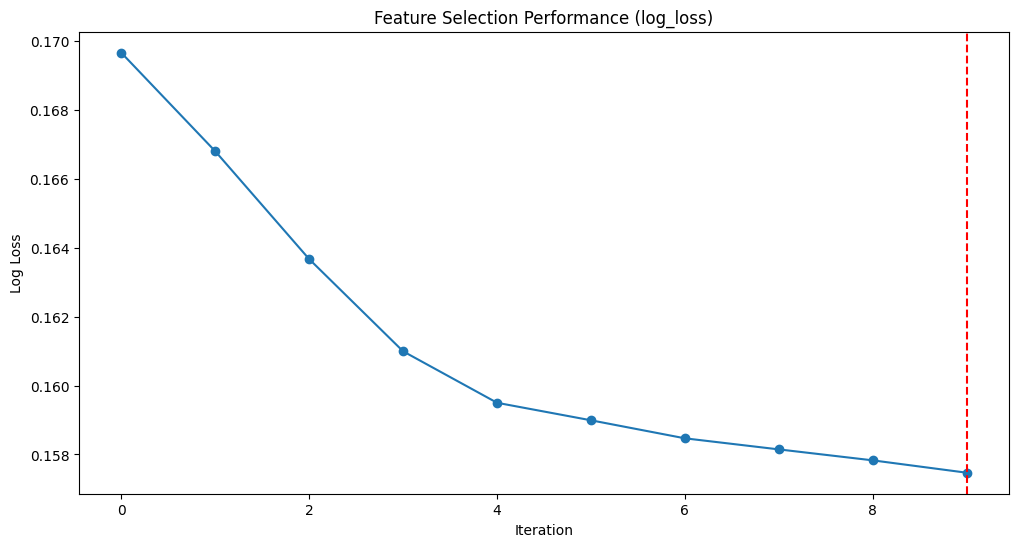

In [46]:
X_selected, results = incremental_feature_selection(
    X=data.drop(columns=['language','language_group','is_root']),
    y=data['is_root'],
    groups=data['sentence'],  # Add your sentence groups here
    estimator=lgb.LGBMClassifier(),
    metric='log_loss',
    cv=5
)

In [47]:
results

{'optimal_features': ['betweeness_cent',
  'vote_rank_score',
  'number_of_nodes',
  'neighbor_degree_mean',
  'language_Japanese',
  'min_subtree_depth',
  'language_group_Germanic',
  'language_group_Romance',
  'language_Hindi',
  'language_Chinese'],
 'optimal_score': np.float64(0.15747057405796716),
 'performance_history': [np.float64(0.169669768047971),
  np.float64(0.16680803129549493),
  np.float64(0.16367549354713443),
  np.float64(0.16099663207561163),
  np.float64(0.15950206154813112),
  np.float64(0.15899334891659983),
  np.float64(0.15846972119054198),
  np.float64(0.15814795633037015),
  np.float64(0.157829746220219),
  np.float64(0.15747057405796716)],
 'feature_history': [['betweeness_cent'],
  ['betweeness_cent', 'vote_rank_score'],
  ['betweeness_cent', 'vote_rank_score', 'number_of_nodes'],
  ['betweeness_cent',
   'vote_rank_score',
   'number_of_nodes',
   'neighbor_degree_mean'],
  ['betweeness_cent',
   'vote_rank_score',
   'number_of_nodes',
   'neighbor_degree